<a href="https://colab.research.google.com/github/Sanket2010/internship-python-/blob/master/MSPcup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h2>Prerequisite</h2>


Collect Data

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages

In [ ]:
!zip -r data_Language_final.zip /content/Language_Detection_Dataset

Data Moving

In [ ]:
!unzip  /content/drive/MyDrive/data_Language_final.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/Language_Detection_Dataset/Train/English/telugu_s01_511.wav  
  inflating: content/Language_Detection_Dataset/Train/English/bangla_s01_214.wav  
 extracting: content/Language_Detection_Dataset/Train/English/malayalam_s02_418.wav.png  
  inflating: content/Language_Detection_Dataset/Train/English/malayalam_s02_716.wav  
 extracting: content/Language_Detection_Dataset/Train/English/malayalam_s02_276.wav.png  
  inflating: content/Language_Detection_Dataset/Train/English/telugu_s01_178.wav  
  inflating: content/Language_Detection_Dataset/Train/English/malayalam_s02_479.wav  
  inflating: content/Language_Detection_Dataset/Train/English/telugu_s01_461.wav  
  inflating: content/Language_Detection_Dataset/Train/English/bangla_s01_130.wav  
 extracting: content/Language_Detection_Dataset/Train/English/malayalam_s02_662.wav.png  
  inflating: content/Language_Detection_Dataset/Train/English/telugu_s01_151.wav  
  inflati

In [ ]:
%rm -rf "/content/Language_Detection_Dataset"

In [ ]:
import shutil
shutil.move("/content/content/Language_Detection_Dataset", "/content/")

'/content/Language_Detection_Dataset'

Data Preparation

In [ ]:
train = 'Train'
test = 'Test'

eng = 'English'
guj = 'Gujarati'
hin = 'Hindi'

languages = [eng, guj,hin]
categories = [train, test]

original_dataset_paths = {}

original_dataset_paths[eng] = '/content/Language_Detection_Dataset/Train/English'
original_dataset_paths[guj] = '/content/Language_Detection_Dataset/Train/Gujarati'
original_dataset_paths[hin] = '/content/Language_Detection_Dataset/Train/Hindi'

target_root_path = '/content/Language_Detection_Dataset/'
dataset_root_path = '/content/Language_Detection_Dataset/'


batch_size = 128
image_width = 500
image_height = 128

sample_rate = 8000

num_files_to_take_for_each_language = 90

train_path = dataset_root_path + train

validation_split = 0.2
initial_learning_rate = 0.045

num_classes = len(languages)
model_file = dataset_root_path + 'model.h5'

augment_data_factor = 1.0
train_rate = 0.8  # Use 80 % of the data for training and the rest for testing

In [ ]:
import os
import librosa as lr
from librosa.display import waveplot
from glob import glob
from random import shuffle
from shutil import copy2
import matplotlib.pyplot as plt
from IPython.display import Audio
import imageio
import soundfile as sf
import numpy as np
import pandas as pd
import warnings

import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
for category in categories:

    if category == train:
        num_files = int(num_files_to_take_for_each_language * train_rate)
    else:
        num_files = int(num_files_to_take_for_each_language * (1.0 - train_rate))

    for lang in languages:
        folder = target_root_path + category + '/' + lang + '/'
        all_files = glob(folder + '*.mp3') + glob(folder + '*.wav')

        if len(all_files) < (num_files - 1):
            raise Exception('Folder \"' + folder + '\" only contains ' + str(len(all_files)) + ' files instead of ' + str(num_files) + '!')

print('Okay!')

Okay!


In [ ]:
warnings.simplefilter('ignore', UserWarning)

for category in categories:
    for lang in languages:
        duration_sec = 0.0

        folder = target_root_path + category + '/' + lang + '/'
        all_files = glob(folder + '*.mp3') + glob(folder + '*.wav')

        for file in all_files:
            duration_sec += lr.core.get_duration(filename=file)

        duration_h = duration_sec / 60.0 /60.0
        print('Total duration of ' + lang + ' ' + category + ' is ' + str(round(duration_h, 1)) + ' h')

warnings.simplefilter('default', UserWarning)

#<h2> Data Augmentation </h2>

In [ ]:
def load_audio_file(audio_file_path):
    warnings.simplefilter('ignore', UserWarning)

    audio_segment, sample_rate = lr.load(audio_file_path)
    return audio_segment, sample_rate

    warnings.simplefilter('default', UserWarning)

In [ ]:
def add_noise(audio_segment, gain):
    num_samples = audio_segment.shape[0]
    noise = gain * np.random.normal(size=num_samples)
    return audio_segment + noise

In [ ]:
audio_files = {}

for lang in languages:
    for category in categories:
        audio_files[lang + '.' + category] = glob(dataset_root_path + category + '/' + lang + '/*.mp3') + glob(dataset_root_path + category + '/' + lang + '/*.wav')

print(audio_files.keys())

dict_keys(['English.Train', 'English.Test', 'Gujarati.Train', 'Gujarati.Test', 'Hindi.Train', 'Hindi.Test'])


In [ ]:
key = list(audio_files.keys())[2]
audio_file = audio_files[key][2]
audio_file

'/content/Language_Detection_Dataset/Train/Gujarati/5601.mp3'

##example

In [ ]:
audio, sample_rate = load_audio_file(audio_file)

Audio(audio, rate=sample_rate)

In [ ]:
audio_segment_with_noise = add_noise(audio, 0.005)

Audio(audio_segment_with_noise, rate=sample_rate)

# function

In [ ]:
def augment_audio_file_with_noise(audio_file_path):
    audio_segment, sample_rate = load_audio_file(audio_file_path)
    # audio_segment_with_noise = add_noise(audio_segment, 0)
    audio_file_path_without_extension = os.path.splitext(audio_file_path)[0]
    augmented_audio_file_path = audio_file_path_without_extension + '.wav'
    sf.write(augmented_audio_file_path, audio_segment, sample_rate)

In [ ]:
for lang in languages:
    category = test

    all_audio_files = audio_files[lang + '.' + category]

    num_files = int(len(all_audio_files) * augment_data_factor)

    for i in range(num_files):
        if i % (num_files / 1) == 0:
            print('Still processing ' + lang + ' ' + category + ' ' + str(i) + '/' + str(num_files))
        augment_audio_file_with_noise(all_audio_files[i])

Still processing English Test 0/80
Still processing Gujarati Test 0/80
Still processing Hindi Test 0/80


In [ ]:
for lang in languages:
    category = train

    all_audio_files = audio_files[lang + '.' + category]

    num_files = int(len(all_audio_files) * augment_data_factor)

    for i in range(num_files):
        # if i % (num_files / 10) == 0:
        print('Still processing ' + lang + ' ' + category + ' ' + str(i) + '/' + str(num_files))
        augment_audio_file_with_noise(all_audio_files[i])

Streaming output truncated to the last 5000 lines.
Still processing Gujarati Train 1166/3027
Still processing Gujarati Train 1167/3027
Still processing Gujarati Train 1168/3027
Still processing Gujarati Train 1169/3027
Still processing Gujarati Train 1170/3027
Still processing Gujarati Train 1171/3027
Still processing Gujarati Train 1172/3027
Still processing Gujarati Train 1173/3027
Still processing Gujarati Train 1174/3027
Still processing Gujarati Train 1175/3027
Still processing Gujarati Train 1176/3027
Still processing Gujarati Train 1177/3027
Still processing Gujarati Train 1178/3027
Still processing Gujarati Train 1179/3027
Still processing Gujarati Train 1180/3027
Still processing Gujarati Train 1181/3027
Still processing Gujarati Train 1182/3027
Still processing Gujarati Train 1183/3027
Still processing Gujarati Train 1184/3027
Still processing Gujarati Train 1185/3027
Still processing Gujarati Train 1186/3027
Still processing Gujarati Train 1187/3027
Still processing Gujarati

#<h2>Pre-Process</h2>

In [ ]:
def fix_audio_segment_to_10_seconds(audio_segment):
    target_len = 10 * sample_rate
    audio_segment = np.concatenate([audio_segment]*3, axis=0)
    audio_segment = audio_segment[0:target_len]

    return audio_segment

In [ ]:
def spectrogram(audio_segment):
    # Compute mel-scaled spectrogram image
    hl = audio_segment.shape[0] // image_width
    spec = lr.feature.melspectrogram(audio_segment, n_mels=image_height, hop_length=int(hl))

    # Logarithmic amplitudes
    image = lr.core.power_to_db(spec)

    # Convert to numpy matrix
    image_np = np.asmatrix(image)

    # Normalize and scale
    image_np_scaled_temp = (image_np - np.min(image_np))

    image_np_scaled = image_np_scaled_temp / np.max(image_np_scaled_temp)

    return image_np_scaled[:, 0:image_width]

In [ ]:
def to_integer(image_float):
    # range (0,1) -> (0,255)
    image_float_255 = image_float * 255.

    # Convert to uint8 in range [0:255]
    image_int = image_float_255.astype(np.uint8)

    return image_int

In [ ]:
audio_files = {}

for lang in languages:
    for category in categories:
        dataset_path = dataset_root_path + category + '/' + lang

        # If you wish to preprocess all data use the following command
        # audio_files[lang + '.' + category] = glob(dataset_path + '/*.wav') + glob(dataset_path + '/*.mp3')

        # If you only wish to preprocess augmented data use the following command
        audio_files[lang + '.' + category] = glob(dataset_path + '/*.wav')

print(audio_files.keys())

dict_keys(['English.Train', 'English.Test', 'Gujarati.Train', 'Gujarati.Test', 'Hindi.Train', 'Hindi.Test'])


In [ ]:
audio_files

{'English.Test': ['/content/Language_Detection_Dataset/Test/English/malayalam_s02_734.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_724.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_742.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_707.wav',
  '/content/Language_Detection_Dataset/Test/English/telugu_s01_751.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_733.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_713.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_711.wav',
  '/content/Language_Detection_Dataset/Test/English/telugu_s01_764.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_721.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_723.wav',
  '/content/Language_Detection_Dataset/Test/English/bangla_s01_776.wav',
  '/content/Language_Detection_Dataset/Test/English/odiya_s01_739.wav',
  '/content/Language_Detection_Dataset/Te

In [ ]:
key = list(audio_files.keys())[0]
audio_file = audio_files[key][0]
audio_file

'/content/Language_Detection_Dataset/Train/English/bangla_s01_526.wav'

In [ ]:
def load_audio_file(audio_file_path):
    warnings.simplefilter('ignore', UserWarning)

    audio_segment, _ = lr.load(audio_file_path, sr=sample_rate)
    return audio_segment

    warnings.simplefilter('default', UserWarning)

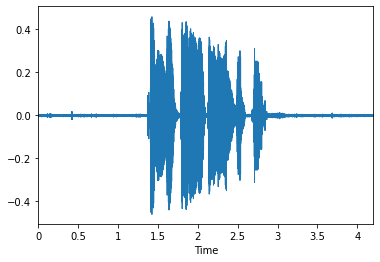

In [ ]:
audio = load_audio_file(audio_file)

waveplot(audio, sr=sample_rate)
plt.show()

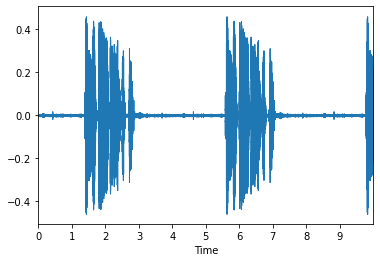

In [ ]:
audio_fixed = fix_audio_segment_to_10_seconds(audio)

waveplot(audio_fixed, sr=sample_rate)
plt.show()

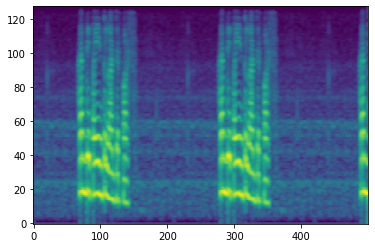

In [ ]:
spectro = spectrogram(audio_fixed)

plt.imshow(spectro, origin='lower', aspect='auto')
plt.show()

In [ ]:
def audio_to_image_file(audio_file):
    out_image_file = audio_file + '.png'
    audio = load_audio_file(audio_file)
    # audio_fixed = fix_audio_segment_to_10_seconds(audio)
    if np.count_nonzero(audio_fixed) != 0:
        spectro = spectrogram(audio)
        spectro_int = to_integer(spectro)
        imageio.imwrite(out_image_file, spectro_int)
    else:
        print('WARNING! Detected an empty audio signal. Skipping...')

In [ ]:
def load_audio_file(audio_file_path):
    warnings.simplefilter('ignore', UserWarning)

    audio_segment, _ = lr.load(audio_file_path, sr=sample_rate)
    return audio_segment

    warnings.simplefilter('default', UserWarning)

for lang in languages:
    for category in categories:
        all_audio_files = audio_files[lang + '.' + category]

        num_files = len(all_audio_files)

        for i in range(num_files):
            # if i % (num_files / 50) == 0:
            print('Still processing ' + lang + ' ' + category + ' ' + str(i) + '/' + str(num_files))
            audio_to_image_file(all_audio_files[i])

Still processing English Train 0/2956


NameError: ignored

In [ ]:
def load_audio_file(audio_file_path):
    warnings.simplefilter('ignore', UserWarning)

    audio_segment, _ = lr.load(audio_file_path, sr=sample_rate)
    return audio_segment

    warnings.simplefilter('default', UserWarning)

lang = guj
category = test
all_audio_files = audio_files[lang + '.' + category]

num_files = len(all_audio_files)

for i in range(num_files):
    # if i % (num_files / 50) == 0:
    print('Still processing ' + lang + ' ' + category + ' ' + str(i) + '/' + str(num_files))
    audio_to_image_file(all_audio_files[i])

Still processing Gujarati Test 0/80
Still processing Gujarati Test 1/80
Still processing Gujarati Test 2/80
Still processing Gujarati Test 3/80
Still processing Gujarati Test 4/80
Still processing Gujarati Test 5/80
Still processing Gujarati Test 6/80
Still processing Gujarati Test 7/80
Still processing Gujarati Test 8/80
Still processing Gujarati Test 9/80
Still processing Gujarati Test 10/80
Still processing Gujarati Test 11/80
Still processing Gujarati Test 12/80
Still processing Gujarati Test 13/80
Still processing Gujarati Test 14/80
Still processing Gujarati Test 15/80
Still processing Gujarati Test 16/80
Still processing Gujarati Test 17/80
Still processing Gujarati Test 18/80
Still processing Gujarati Test 19/80
Still processing Gujarati Test 20/80
Still processing Gujarati Test 21/80
Still processing Gujarati Test 22/80
Still processing Gujarati Test 23/80
Still processing Gujarati Test 24/80
Still processing Gujarati Test 25/80
Still processing Gujarati Test 26/80
Still proce

/content/Language_Detection_Dataset/Test/English/odiya_s01_728.wav.png


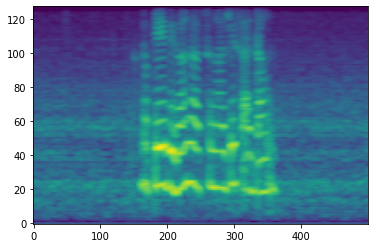

(128, 500)


In [ ]:
list_of_image_files = glob(dataset_root_path + test + '/' + eng + '/*.png')
image_file_path = list_of_image_files[0]

print(image_file_path)

image = imageio.imread(image_file_path)

plt.imshow(image, origin='lower', aspect='auto')
plt.show()

print(image.shape)

In [ ]:
audio_file_path = os.path.splitext(image_file_path)[0]

Audio(audio_file_path)

In [ ]:
num_files

2956

In [ ]:
all_audio_files

['/content/Language_Detection_Dataset/Test/Hindi/19992.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19948.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19974.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/20000.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19993.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19986.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19947.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19989.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19954.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19999.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19950.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/20024.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19988.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19961.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/20025.mp3',
 '/content/Language_Detection_Dataset/Test/Hindi/19964.mp3',
 '/content/Language_Dete

#<h2>Data_ Training </h2>

In [ ]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per Epoch: 56
Validation steps: 14


In [ ]:
image_data_generator = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')


Found 7236 images belonging to 3 classes.
Found 1807 images belonging to 3 classes.


Model Summary

In [ ]:
train_path

'/content/Language_Detection_Dataset/Train'

In [ ]:
img_input = Input(shape=(image_height, image_width, 1))
img_conc = Concatenate(axis=3, name='input_concat')([img_input, img_input, img_input])
model = InceptionV3(input_tensor=img_conc, weights=None, include_top=True, classes=3)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 500, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_concat (Concatenate)     (None, 128, 500, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 249, 32)  864         ['input_concat[0][0]']

In [ ]:
model.compile(optimizer=RMSprop(lr=initial_learning_rate, clipvalue=2.0), loss='categorical_crossentropy', metrics=['accuracy'])


#<h2>Model Fitting




In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)


In [ ]:
def step_decay(epoch, lr):
    drop = 0.94
    epochs_drop = 2.0
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate_decay = LearningRateScheduler(step_decay, verbose=1)

In [ ]:
history_1 = model.fit(train_generator, validation_data=validation_generator, epochs=20, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping, learning_rate_decay])



Epoch 1: LearningRateScheduler setting learning rate to 0.04500000178813934.
Epoch 1/20
56/56 [==============================] - 91s 1s/step - loss: 4.1082 - accuracy: 0.4980 - val_loss: 480458496278528.0000 - val_accuracy: 0.3276 - lr: 0.0450

Epoch 2: LearningRateScheduler setting learning rate to 0.042300001680850983.
Epoch 2/20
56/56 [==============================] - 69s 1s/step - loss: 1.5125 - accuracy: 0.5891 - val_loss: 590538816.0000 - val_accuracy: 0.3259 - lr: 0.0423

Epoch 3: LearningRateScheduler setting learning rate to 0.03976200073957443.
Epoch 3/20
56/56 [==============================] - 69s 1s/step - loss: 0.9395 - accuracy: 0.7589 - val_loss: 1001540992.0000 - val_accuracy: 0.3471 - lr: 0.0398

Epoch 4: LearningRateScheduler setting learning rate to 0.03513370451182127.
Epoch 4/20
56/56 [==============================] - 69s 1s/step - loss: 0.5601 - accuracy: 0.8505 - val_loss: 64554.3008 - val_accuracy: 0.3460 - lr: 0.0351

Epoch 5: LearningRateScheduler setting 

In [ ]:
model.save(model_file)

In [ ]:
shutil.move("/content/Language_Detection_Dataset/model_Language_best.h5", "/content/drive/MyDrive")

'/content/drive/MyDrive/model_Language_best.h5'

In [ ]:
ref = dict(zip(list(train_generator.class_indices.values()),list(train_generator.class_indices.keys())))

#<h2>Evaluation</h2>

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# model = load_model(model_file)
model = load_model('/content/drive/MyDrive/model_Language_best.h5')

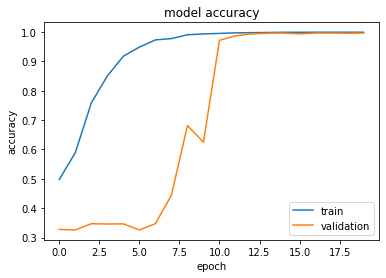

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
test_path = dataset_root_path + test

In [ ]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))


Evaluation steps: 1


In [ ]:
image_data_generator = ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale')


Found 240 images belonging to 3 classes.


In [ ]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)


1/1 [==============================] - 1s 565ms/step - loss: 4.0920e-04 - accuracy: 1.0000


In [ ]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')


Test accuracy: 100.0 %


In [ ]:
evaluation_generator.class_indices

{'English': 0, 'Gujarati': 1, 'Hindi': 2}

#<h1> User App (Back-end)</h1>

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  return audio, sr

In [ ]:
import os
import librosa as lr
from librosa.display import waveplot
from glob import glob
from random import shuffle
from shutil import copy2
import matplotlib.pyplot as plt
from IPython.display import Audio
import imageio
import soundfile as sf
import numpy as np
import pandas as pd
import warnings


In [ ]:

import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
sample_rate = 8000
batch_size = 128
image_width = 500
image_height = 128

def load_audio_file(audio_file_path):
    warnings.simplefilter('ignore', UserWarning)

    audio_segment, _ = lr.load(audio_file_path, sr=sample_rate)
    return audio_segment

    warnings.simplefilter('default', UserWarning)

In [ ]:
def to_integer(image_float):
    # range (0,1) -> (0,255)
    image_float_255 = image_float * 255.

    # Convert to uint8 in range [0:255]
    image_int = image_float_255.astype(np.uint8)

    return image_int

In [ ]:
def spectrogram(audio_segment):
    # Compute mel-scaled spectrogram image
    hl = audio_segment.shape[0] // image_width
    spec = lr.feature.melspectrogram(audio_segment, n_mels=image_height, hop_length=int(hl))

    # Logarithmic amplitudes
    image = lr.core.power_to_db(spec)

    # Convert to numpy matrix
    image_np = np.asmatrix(image)

    # Normalize and scale
    image_np_scaled_temp = (image_np - np.min(image_np))

    image_np_scaled = image_np_scaled_temp / np.max(image_np_scaled_temp)

    return image_np_scaled[:, 0:image_width]

In [ ]:
def audio_to_image_file(audio_file):
    out_image_file = audio_file + '.png'
    audio = load_audio_file(audio_file)
    # audio_fixed = fix_audio_segment_to_10_seconds(audio)
    # if np.count_nonzero(audio_fixed) != 0:
    spectro = spectrogram(audio)
    spectro_int = to_integer(spectro)
    imageio.imwrite(out_image_file, spectro_int)
    # else:
        # print('WARNING! Detected an empty audio signal. Skipping...')

In [ ]:
from keras.models import load_model
model_file = '/content/drive/MyDrive/model_Language_best.h5'
model = load_model(model_file)

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 500, 1))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image


#<h2>User App

In [ ]:
import scipy
audio, sr = get_audio()
scipy.io.wavfile.write('recording.wav', sr, audio)

In [ ]:
audio_to_image_file('/content/recording.wav')

In [ ]:
 image = load('/content/recording.wav.png')
 preds = model.predict(image)
 print(preds)
 predi = np.argmax(preds)
 labpred = ref[predi]
 print("You were speaking : " + labpred)

[[3.0403108e-08 9.9999285e-01 7.1120421e-06]]
You were speaking : Gujarati


In [ ]:
!rm /content/recording.wav
!rm /content/recording.wav.png